In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_Compress import generate_Y, compress
import pandas as pd
import itertools
import dask
from dask.distributed import Client, progress
import seaborn as sns
import time
import os.path

In [2]:
save_path = os.path.join('./result/')

In [3]:
# Work on previously saved data
params_df = pd.read_csv('result//param_Mon_May_23_21_46_49_2022.csv')
results_df = pd.read_csv('result//results_Mon_May_23_21_46_49_2022.csv')
total_df = pd.read_csv('result//total_Mon_May_23_21_47_07_2022.csv')

In [4]:
for index in params_df.columns:
    if (index == 'Unnamed: 0') :
        params_df.drop('Unnamed: 0', axis = 1, inplace=True)

for index in results_df.columns:
    if (index == 'Unnamed: 0') :
        results_df.drop('Unnamed: 0', axis = 1, inplace=True)
for index in total_df.columns:
    if (index == 'Unnamed: 0') :
        total_df.drop('Unnamed: 0', axis = 1, inplace=True)


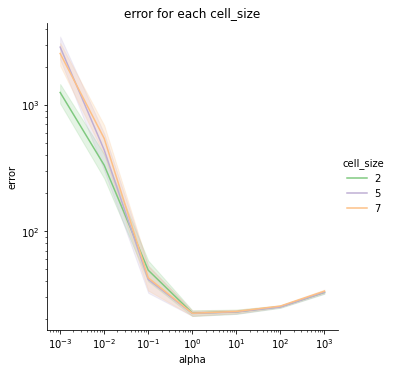

In [5]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', hue = 'cell_size')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each cell_size')
# fig.savefig(os.path.join(save_path, "alpha_error_per_size" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

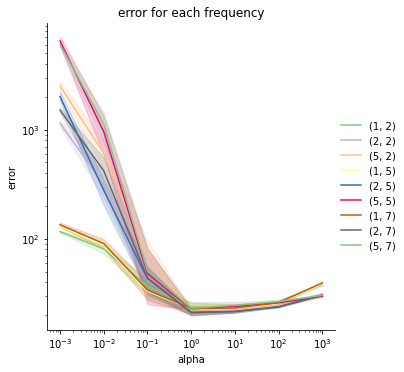

In [33]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', 
                  hue = params_df[['sparse_freq', 'cell_size']].apply(tuple, axis = 1))
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each frequency')
# fig.savefig(os.path.join(save_path, "alpha_error_per_freq" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

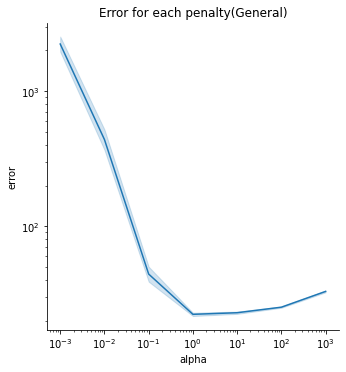

In [7]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='Error for each penalty(General)')
# fig.savefig(os.path.join(save_path, "alpha_error_general" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

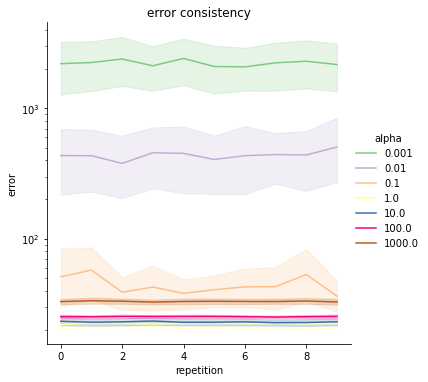

In [76]:
# To show how consistent randomly generated V1 weight would be for each rep. it should be about same for each repetition

fig = sns.relplot(data = params_df, x = 'repetition', y = 'error', kind='line', palette='Accent', hue = 'alpha')
fig.set(title='error consistency')
fig.set(yscale='log')
fig.savefig(os.path.join(save_path, "alpha_error_consistency" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".pdf"), dpi = 200)

In [68]:
params_df.groupby(by=['num_cell', 'cell_size', 'sparse_freq', 'alpha']).mean().sort_values(by='error', ascending= True).drop('repetition', axis = 1).head(1)

,,,,error
num_cell,cell_size,sparse_freq,alpha,
500,7,2,0.01,12.709595


In [70]:
params_df.groupby(by=['num_cell', 'cell_size', 'sparse_freq', 'alpha']).mean().drop('repetition', axis = 1).

error    12.709595
dtype: float64

In [10]:
compress_param_df = pd.read_csv('result//Compress_param_Wed_May_25_14_52_32_2022.csv')

seaborn.axisgrid.FacetGrid

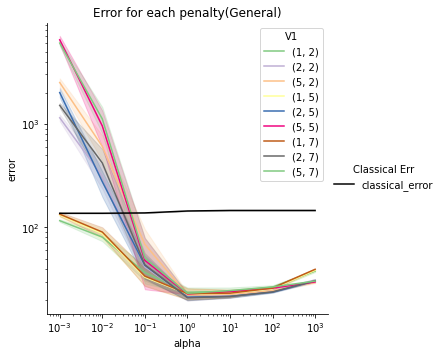

In [74]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', 
                  hue = params_df[['sparse_freq', 'cell_size']].apply(tuple, axis = 1), legend = False)

fig.set(title='Error for each penalty(General)')
fig.map(sns.lineplot, x = 'alpha', y = 'error', data = compress_param_df, 
        label= 'classical_error', color = 'black', legend = True).add_legend(title='Classical Err', loc = 'right')
fig.set(yscale='log')
fig.set(xscale='log')
plt.legend(title = 'V1', labels =['(1, 2)', '(2, 2)', '(5, 2)', '(1, 5)', '(2, 5)', '(5, 5)', '(1, 7)', '(2, 7)', '(5, 7)'])
# plt.legend(title = 'Classical', label = ['classic'])

# compress_fig = sns.relplot(data = compress_param_df, x = 'alpha', y = 'error', kind= 'line')
# compress_fig.set(yscale='log')
# compress_fig.set(xscale='log')
type(fig)